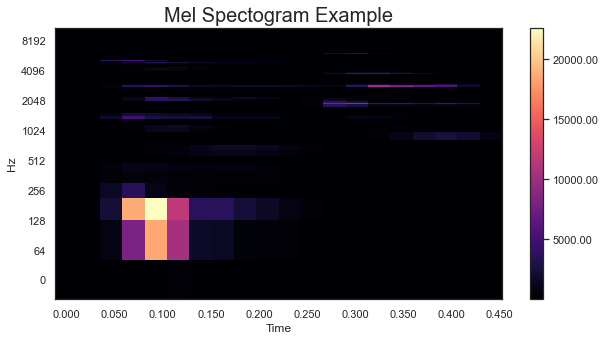

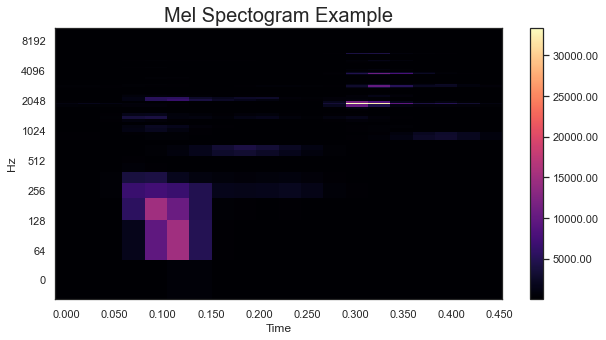

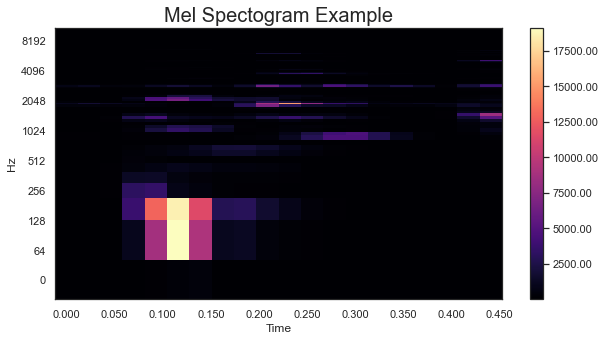

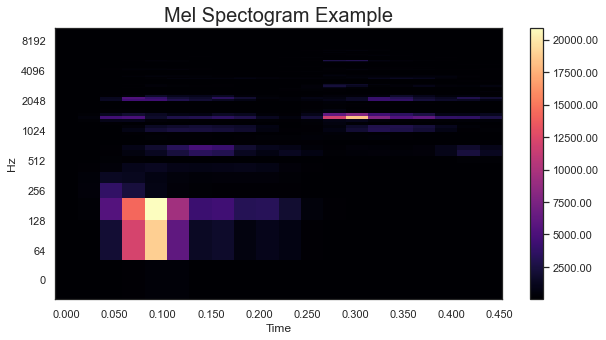

In [28]:
import audioUtils as u

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

import librosa

sns.set(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

file_path = 'sampleaudio.wav'
y,sr = librosa.load(file_path,sr=22050)

def plot(input):
    fig, ax = plt.subplots(figsize=(10, 5))
    # Plot the mel spectogram
    img = librosa.display.specshow(input,
                                x_axis='time',
                                y_axis='log',
                                ax=ax)
    ax.set_title('Mel Spectogram Example', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

preAudio = u.preprocessAudio(file_path)
for i in preAudio:
    plot(i)





training\owl


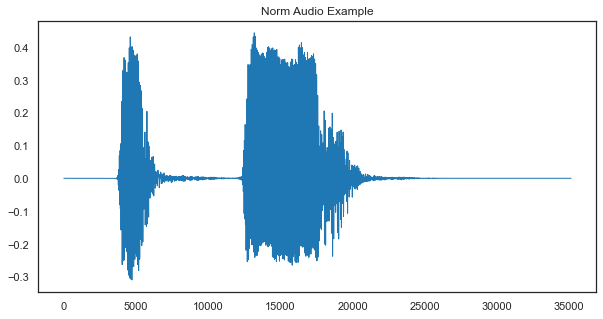

0


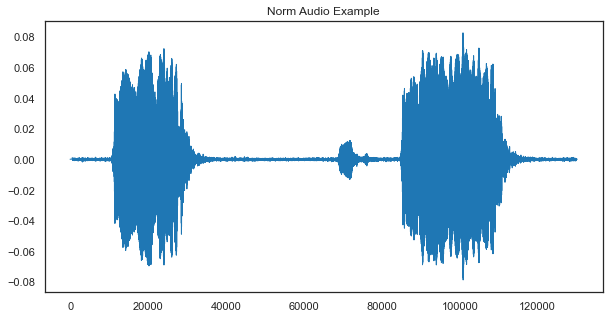

4


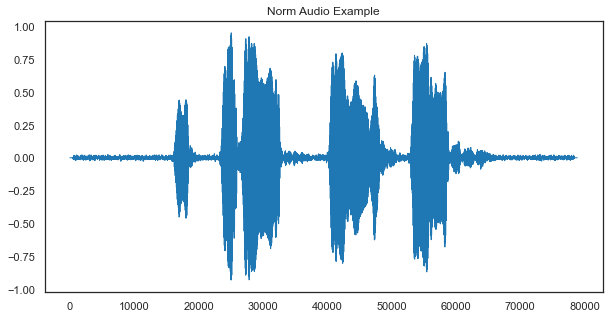

1
training\seagull


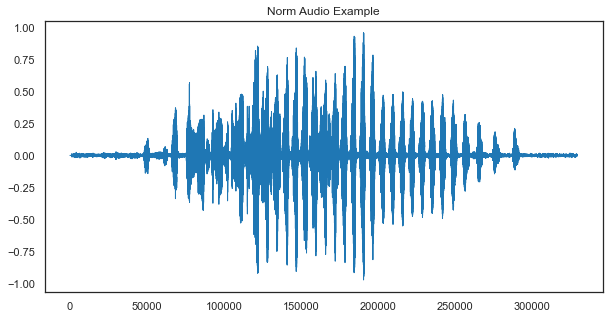

4


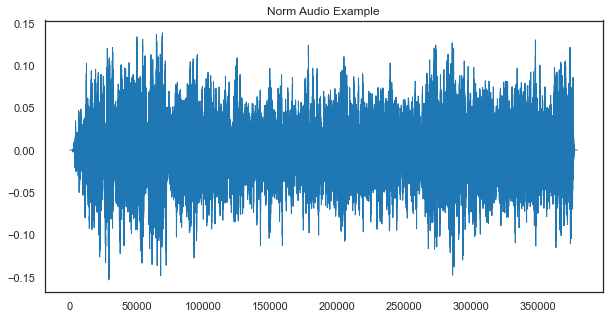

37
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['owl', 'seagull']


In [54]:
# all tracks will be the X features and classification will be the target y
all_tracks = []
classification = []
def plot(input):
    fig, ax = plt.subplots(figsize=(10, 5))
    # Plot the mel spectogram
    img = librosa.display.specshow(input,
                                x_axis='time',
                                y_axis='log',
                                ax=ax)
    ax.set_title('Mel Spectogram Example', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

import os
# assign directory
directory = 'training'
 
# iterate over files in
# that directory
nameIndex = []

def cut_audio(audio, step = 10000):
  audio_pieces = []
  y_split = librosa.effects.split(audio, top_db=20)
  for i in y_split:
    segment = audio[i[0]:i[1]]
    for j in range(0, (len(segment)-step), step):

      audio_pieces.append(segment[j:j+step])
  return audio_pieces
  



def preprocessAudio(filePath, size = 10000, db = False):
  list_matrices = []
  y,sr = librosa.load(filePath,sr=22050)
  aduio_pieces = cut_audio(y, size)
  for audio_piece in aduio_pieces:
   #  normalized_audio = (audio_piece - np.mean(audio_piece)) / np.std(audio_piece)
    melspect = librosa.feature.melspectrogram(y = audio_piece)
    if db:
        melspect = librosa.amplitude_to_db(melspect, ref=np.max)
    list_matrices.append(melspect)
  return list_matrices




i = 1
for foldername in os.listdir(directory):
   folder_path = os.path.join(directory, foldername)
   print(folder_path)
   # checking if it is a file
   #  if os.path.isfile(f):
   nameIndex.append(foldername)
   for file in os.listdir(folder_path):
      file_path = os.path.join(folder_path, file)
      y,sr = librosa.load(file_path,sr=22050)
      audio_pieces = u.cut_audio(y)
      pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Norm Audio Example',
                 color=color_pal[0])
      plt.show()
      audio_piece = preprocessAudio(file_path)
      # for i in audio_piece:
      #    plot(i)
      all_tracks += audio_piece
      print(len(audio_piece))
      classification += ([i]*len(audio_piece))
   i -= 1

print(classification)
print(nameIndex)




In [55]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 20, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# model.add(layers.Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 18, 32)       320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 9, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 7, 64)         18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 3, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 1, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [56]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(all_tracks), 
                                                    np.array(classification),
                                                    test_size=0.33,
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test,
                                                test_size=0.5,
                                                random_state=42)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
print(X_train.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(X_test.shape)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
print(X_val.shape)


(30, 128, 20, 1)
(8, 128, 20, 1)
(8, 128, 20, 1)


In [57]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])
# X_train = X_train.reshape(1, 128, 196, 1)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
                    

Epoch 1/10
1/1 [==============================] - 1s 541ms/step - loss: 0.7578 - accuracy: 0.8667 - val_loss: 24.8466 - val_accuracy: 0.8750
Epoch 2/10
1/1 [==============================] - 0s 49ms/step - loss: 0.3800 - accuracy: 1.0000 - val_loss: 89.3065 - val_accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 32ms/step - loss: 0.1809 - accuracy: 1.0000 - val_loss: 190.5389 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 0s 33ms/step - loss: 0.0613 - accuracy: 1.0000 - val_loss: 292.4090 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 0s 31ms/step - loss: 0.0217 - accuracy: 1.0000 - val_loss: 369.4826 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 0s 33ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 422.2943 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 0s 31ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 467.0602 - val_accuracy: 0.8750
Epoch 8/10
1/1

1/1 - 0s - loss: 0.0014 - accuracy: 1.0000


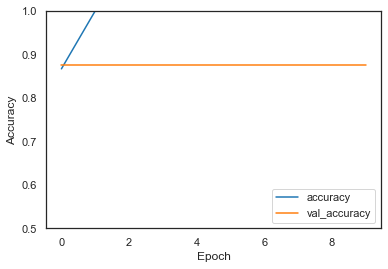

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

https://towardsdatascience.com/machine-learning-on-sound-and-audio-data-3ae03bcf5095
https://www.youtube.com/watch?v=GxBG4wUWf4w

In [60]:



# file_path = "seagulls-5863.mp3"
# y,sr = librosa.load(file_path,sr=22050)

def cut_audio(audio, step = 10000):
  start = 0
  end = len(audio)
  audio_pieces = []
  for i in range(start, end-step, step):
    audio_pieces.append(audio[i:i+step])
  return audio_pieces


def preprocessAudio(filePath, size = 10000, db = False):
  list_matrices = []
  y,sr = librosa.load(filePath,sr=22050)
  audio_pieces = cut_audio(y, size)
  for audio_piece in audio_pieces:
    normalized_audio = (audio_piece - np.mean(audio_piece)) / np.std(audio_piece)
    melspect = librosa.feature.melspectrogram(y = normalized_audio)
    if db:
        melspect = librosa.amplitude_to_db(melspect, ref=np.max)
    list_matrices.append(melspect)
  return list_matrices
# input = preprocessAudio(file_path)
    
# input = np.array(input)
# input = np.reshape(input, (input.shape[0], input.shape[1],input.shape[2], 1))
# print(input.shape)

# test = model.predict(input)
# test = [1 if prediction > 0.5 else 0 for prediction in test]
# print(test)
# test = [key for key, group in groupby(test)]
# calls = tf.math.reduce_sum(test).numpy()

# print(calls)



file_path = "hoot-46198.mp3"
y,sr = librosa.load(file_path,sr=440000)
print(y.shape)

input = preprocessAudio(file_path)
    
input = np.array(input)
input = np.reshape(input, (input.shape[0], input.shape[1],input.shape[2], 1))
print(input.shape)
test = model.predict(input)
test = [1 if prediction > 0.9 else 0 for prediction in test]
print(test)
print(len(test))
# print(test.shape)
from itertools import groupby

test = [key for key, group in groupby(test)]
calls = tf.math.reduce_sum(test).numpy()

calls




(5037120,)
(25, 128, 20, 1)
[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
25


2

https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb